# Neuro-Genomics Course - Home Exercise 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Part 1** - Normalization of sequencing data

#### a) Implement TMM normalization

In [2]:
def tmm_normalization(X, Y, D):
    """TMM normalization method.

    Args:
        X (list or numpy array): Reference vector with values Xi.
        Y (list or numpy array): Normalized vector with values Yi.
        D (float): A constant between 0 and 1.

    Returns:
        X (list or numpy array): The reference vector.
        corrected_Y (list or numpy array):vector Y scaled by the normalization factor.
        factor (float): the normalization factor.

    """
    #Check that X and Y have the same length
    if len(X) != len(Y):
        raise ValueError("X and Y must have the same length")
    if not (0 < D < 1):
        raise ValueError("D must be between 0 and 1")
    

    # Compute the M folds and weights
    M_folds = []
    weights = []
    for Xi, Yi in zip(X, Y):
        if Xi != 0 and Yi != 0:
            Mi = np.log(Yi / Xi)
            Wi = np.sqrt((Xi + Yi) / 2) # Compute the weight
            M_folds.append(Mi)
            weights.append(Wi)
    M_folds = np.array(M_folds)
    weights = np.array(weights)

    # Sort and trim M folds and compute TMM
    sorted_indices = np.argsort(M_folds)
    sorted_M_folds = M_folds[sorted_indices]
    sorted_weights = weights[sorted_indices]
    n = len(M_folds)
    lower_idx = int(np.floor((D / 2) * n)); higher_idx = int(np.ceil((1 - D / 2) * n))
    trimmed_M_folds = sorted_M_folds[lower_idx:higher_idx]; trimmed_weights = sorted_weights[lower_idx:higher_idx]

    TMM = np.sum(trimmed_weights * trimmed_M_folds) / np.sum(trimmed_weights)

    # Correct vector Y
    factor = np.exp(TMM)
    corrected_Y = Y / factor

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(X, bins=30, alpha=0.5, label='X - Reference vector', color='blue')
    plt.hist(Y, bins=30, alpha=0.5, label='Y - Before Normalization', color='red')
    plt.title('Vectors Histogram Before Normalization')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(X, bins=30, alpha=0.5, label='X - Reference vector', color='blue')
    plt.hist(corrected_Y, bins=30, alpha=0.5, label='Y After Normalization', color='green')
    plt.title('Vectors Histogram After Normalization')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return X, corrected_Y, factor

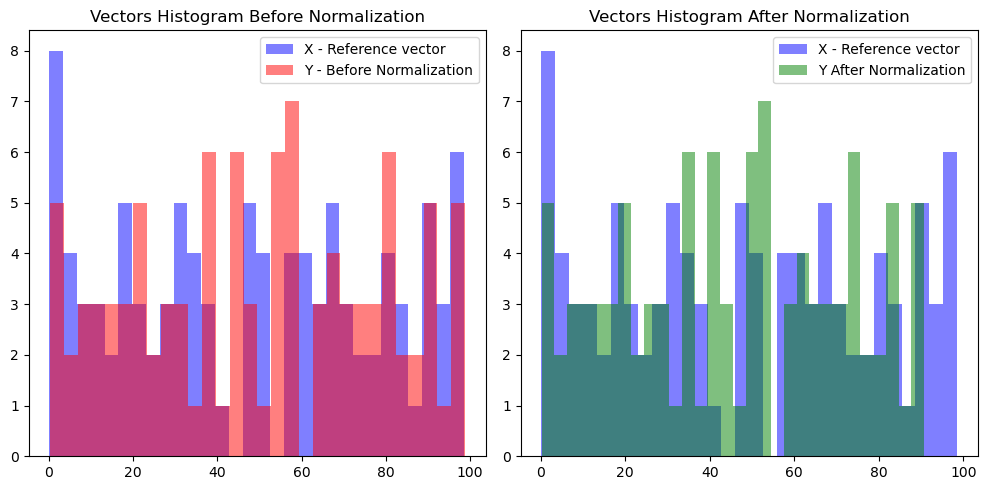

(array([19.80845615, 97.89160948, 88.74052377, 66.95633736, 56.90466164,
        34.07529148, 70.91784272, 61.54466949, 78.88658721, 48.79627118,
        57.97484032, 52.15072354, 72.32518939, 79.36241408, 29.65092277,
         0.45571543, 95.91242419, 38.25012907, 78.20869129, 94.16526876,
        48.19986976, 27.95605403, 98.47901368, 81.59433569, 60.41533658,
        22.67380308,  7.41986259, 17.39177163, 58.71230148, 12.6712873 ,
        85.18218514, 30.60220366, 38.44845866, 49.00492174,  1.56252332,
        48.50597542, 69.82301219,  0.35496461, 65.14929817, 29.45616402,
        59.79786206, 68.93699161, 73.0147659 , 34.97018482, 63.86056925,
        65.28863994,  7.56651335, 66.81009947, 37.73980914, 85.43097391,
        35.76918803, 17.67838478, 68.85485891, 97.89658018, 32.30953426,
        12.2150522 , 93.84205525, 18.13355494, 14.46280529,  6.68648906,
         0.13449023,  9.33752896, 78.50647973, 22.35423666, 57.55108157,
        18.71777973, 60.04546965,  6.6530344 , 11.8

In [3]:
# Test the function with sample data
X = np.random.rand(100) * 100
Y = np.random.rand(100) * 100

tmm_normalization(X, Y, D=0.1)

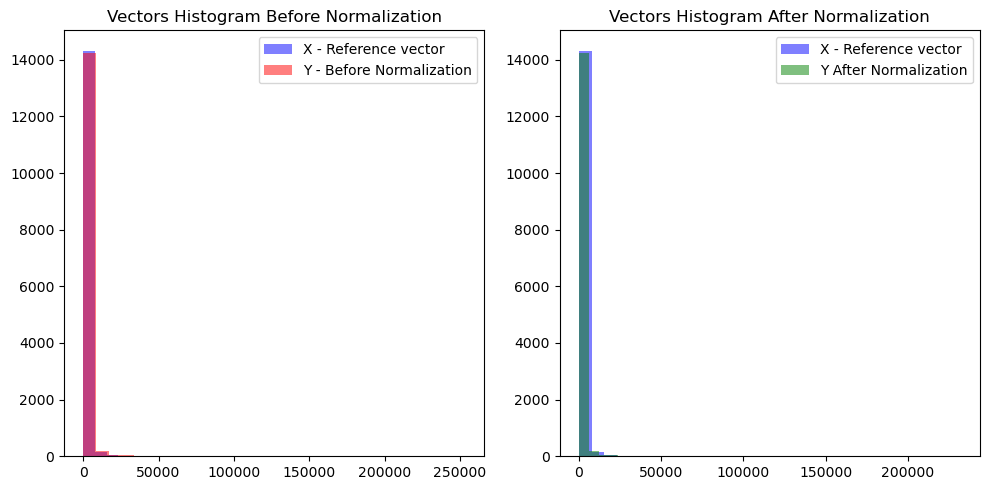

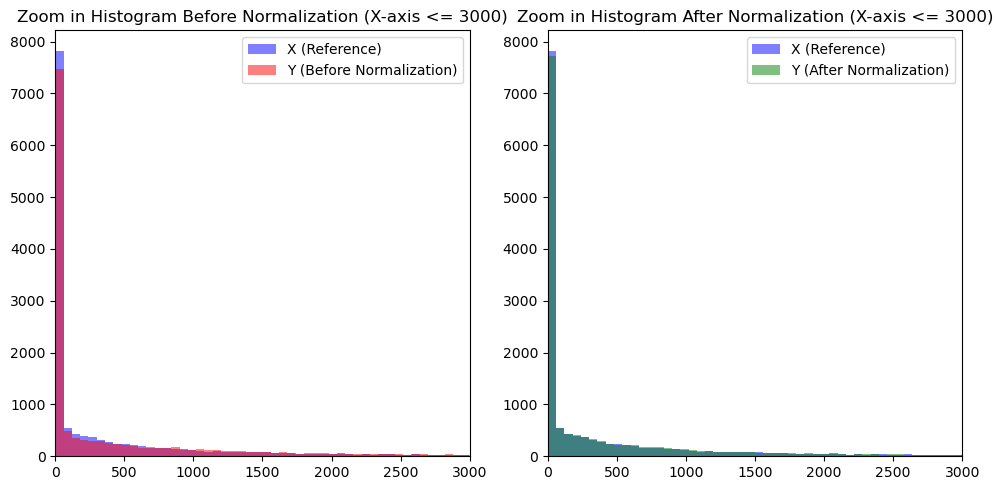

In [4]:
# Run the function on two vectors from the ‘pasilla’ data
file="/Users/adioiz/Documents/Learnings/Neuro-Genomics Course/Home Exc 2/pasilla_gene_counts.tsv"
pasilla_data = pd.read_csv(file, sep='\t', index_col=0)
X = pasilla_data['untreated1'].values
Y = pasilla_data['treated1'].values
D = 0.1

_, Y_normalaized, normalization_factor = tmm_normalization(X, Y, D)
normalization_factor, Y_normalaized[:10], Y


# zoom in on histograms on values below 3,000
x_cutoff = 3000  # cutoff for x-axis
plt.figure(figsize=(10, 5))

# Before normalization
plt.subplot(1, 2, 1)
plt.hist(X[X <= x_cutoff], bins=50, alpha=0.5, label='X (Reference)', color='blue')
plt.hist(Y[Y <= x_cutoff], bins=50, alpha=0.5, label='Y (Before Normalization)', color='red')
plt.title('Zoom in Histogram Before Normalization (X-axis <= 3000)')
plt.legend()
plt.xlim(0, x_cutoff)

# After normalization
plt.subplot(1, 2, 2)
plt.hist(X[X <= x_cutoff], bins=50, alpha=0.5, label='X (Reference)', color='blue')
plt.hist(Y_normalaized[Y_normalaized <= x_cutoff], bins=50, alpha=0.5, label='Y (After Normalization)', color='green')
plt.title('Zoom in Histogram After Normalization (X-axis <= 3000)')
plt.legend()
plt.xlim(0, x_cutoff)

plt.tight_layout()
plt.show()



#### b) Implement quantile normalization

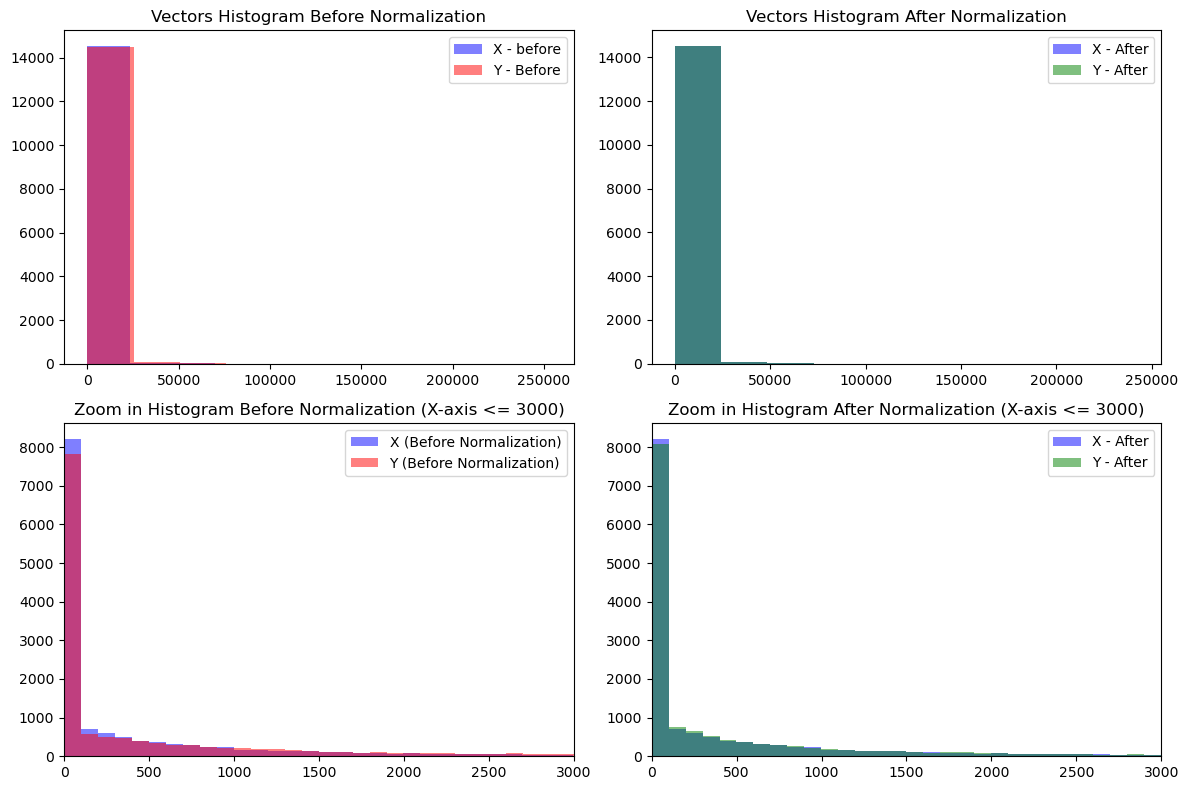

(array([   0,  122,    7, ..., 3162, 7487,    9]),
 array([   0,  112,    3, ..., 2881, 9057,   32]))

In [ ]:
def quantile_normalization(X, Y):
    """quantile normalization method.

    Args:
        X (list or numpy array): Reference vector with values Xi.
        Y (list or numpy array): Normalized vector with values Yi.

    Returns:
        corrected_X (list or numpy array): vector X normalized.
        corrected_Y (list or numpy array): vector Y normalized.
    """
    # Step 1: Stack the vectors into a matrix
    matrix = np.vstack([X, Y])
    
    # Step 2: Sort each vector (row-wise)
    sorted_matrix = np.sort(matrix, axis=1)
    
    # Step 3: Compute the mean of each column across the vectors
    mean_sorted = np.mean(sorted_matrix, axis=0)

    # Step 4: Replace the values with the corresponding column mean (based on ranks)
    normalized_matrix = np.zeros_like(matrix)
    for idx, vector in enumerate(matrix):
        # Get the ranks of the original values
        ranks = np.argsort(np.argsort(vector))
        # Assign the mean values based on the ranks
        normalized_matrix[idx] = mean_sorted[ranks]
    
    # Return the normalized vectors
    corrected_X, corrected_Y = normalized_matrix[0], normalized_matrix[1]
    # zoom in on histograms on values below 3,000
    x_cutoff = 3000  # cutoff for x-axis
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.hist(X, bins=10, alpha=0.5, label='X - before', color='blue')
    plt.hist(Y, bins=10, alpha=0.5, label='Y - Before', color='red')
    plt.title('Vectors Histogram Before Normalization')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.hist(corrected_X, bins=10, alpha=0.5, label='X - After', color='blue')
    plt.hist(corrected_Y, bins=10, alpha=0.5, label='Y - After', color='green')
    plt.title('Vectors Histogram After Normalization')
    plt.legend()
    
    # Before normalization
    plt.subplot(2, 2, 3)
    plt.hist(X[X <= x_cutoff], bins=30, alpha=0.5, label='X - Before', color='blue')
    plt.hist(Y[Y <= x_cutoff], bins=30, alpha=0.5, label='Y - Before', color='red')
    plt.title('Zoom in Histogram Before Normalization (X-axis <= 3000)')
    plt.legend()
    plt.xlim(0, x_cutoff)

    # After normalization
    plt.subplot(2, 2, 4)
    plt.hist(X[X <= x_cutoff], bins=30, alpha=0.5, label='X - After', color='blue')
    plt.hist(Y_normalaized[Y_normalaized <= x_cutoff], bins=30, alpha=0.5, label='Y - After', color='green')
    plt.title('Zoom in Histogram After Normalization (X-axis <= 3000)')
    plt.legend()
    plt.xlim(0, x_cutoff)

    plt.tight_layout()
    plt.show()


    return corrected_X, corrected_Y
    

file="/Users/adioiz/Documents/Learnings/Neuro-Genomics Course/Home Exc 2/pasilla_gene_counts.tsv"
pasilla_data = pd.read_csv(file, sep='\t', index_col=0)
X = pasilla_data['untreated1'].values
Y = pasilla_data['treated1'].values
quantile_normalization(X, Y)
